In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             roc_auc_score, ConfusionMatrixDisplay)
from sklearn.model_selection import GridSearchCV

# Data Preparation

In [2]:
# Loading data
data = pd.read_csv('churn_dataset.csv')

print(data.head())

  Customer Gender Is Senior Partner Dependents  Customer Tenure  \
0            Male         N       N          N                2   
1          Female         N       N          Y                2   
2          Female         N       N          Y                8   
3          Female         N       Y          Y               28   
4            Male         N       N          Y               49   

  Has Phone Service Multiple Lines Internet Plan Online Security  \
0                 Y              N           DSL               Y   
1                 Y              N   Fiber optic               N   
2                 Y              Y   Fiber optic               N   
3                 Y              Y   Fiber optic               N   
4                 Y              Y   Fiber optic               N   

  Device Protection Tech Support Streaming TV Streaming Movies  \
0                 N            N            N                N   
1                 N            N            N           

In [3]:
# Categorical columns for one-hot encoding
categorical_columns = [
    'Customer Gender', 'Is Senior', 'Partner', 'Dependents',
    'Has Phone Service', 'Multiple Lines', 'Internet Plan',
    'Online Security', 'Device Protection', 'Tech Support',
    'Streaming TV', 'Streaming Movies', 'Contract', 
    'Paperless Billing', 'Payment Method', 'Churn Label'
]

data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

print(data_encoded.head())

   Customer Tenure  Monthly Charges Total Charges  Customer Satisfaction  \
0                2            53.85        108.15                      4   
1                2            70.70        151.65                      5   
2                8            99.65         820.5                      3   
3               28           104.80       3046.05                      5   
4               49           103.70        5036.3                      5   

   Customer Gender_Male  Is Senior_Y  Partner_Y  Dependents_Y  \
0                     1            0          0             0   
1                     0            0          0             1   
2                     0            0          0             1   
3                     0            0          1             1   
4                     1            0          0             1   

   Has Phone Service_Y  Multiple Lines_No phone service  ...  Streaming TV_Y  \
0                    1                                0  ...            

In [4]:
# Checking data types for deatures
data_types = data_encoded.dtypes
print(data_types)

Customer Tenure                             int64
Monthly Charges                           float64
Total Charges                              object
Customer Satisfaction                       int64
Customer Gender_Male                        uint8
Is Senior_Y                                 uint8
Partner_Y                                   uint8
Dependents_Y                                uint8
Has Phone Service_Y                         uint8
Multiple Lines_No phone service             uint8
Multiple Lines_Y                            uint8
Internet Plan_Fiber optic                   uint8
Internet Plan_No                            uint8
Online Security_No internet service         uint8
Online Security_Y                           uint8
Device Protection_No internet service       uint8
Device Protection_Y                         uint8
Tech Support_No internet service            uint8
Tech Support_Y                              uint8
Streaming TV_No internet service            uint8


In [5]:
# Total Charges is not float or int so needs to be converted
data_encoded['Total Charges'] = pd.to_numeric(data_encoded['Total Charges'], errors='coerce')

print(data_encoded['Total Charges'].dtype)

float64


In [6]:
# Checking for missing values
missing_values = data_encoded.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

Missing values:
 Total Charges    9
dtype: int64


In [7]:
# Only missing values in Total Charges so printing all rows with missing values for a closer look
missing_total_charges = data_encoded[data_encoded['Total Charges'].isnull()]
print(missing_total_charges)

      Customer Tenure  Monthly Charges  Total Charges  Customer Satisfaction  \
2234                0            52.55            NaN                      4   
2438                0            20.25            NaN                      2   
2568                0            80.85            NaN                      5   
2667                0            25.75            NaN                      4   
2856                0            56.05            NaN                      4   
4331                0            19.85            NaN                      5   
4687                0            25.35            NaN                      3   
5104                0            20.00            NaN                      4   
5719                0            19.70            NaN                      2   

      Customer Gender_Male  Is Senior_Y  Partner_Y  Dependents_Y  \
2234                     0            0          1             0   
2438                     1            0          0             

In [8]:
# Total cahrges appears to be 0 when customer tenure is 0 aka < one month
# Setting Total Charges to Monthly Charges when Customer Tenure is 0
data_encoded.loc[data_encoded['Customer Tenure'] == 0, 'Total Charges'] = data_encoded['Monthly Charges']

In [9]:
# Checking for missing values
missing_values = data_encoded.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

Missing values:
 Series([], dtype: int64)


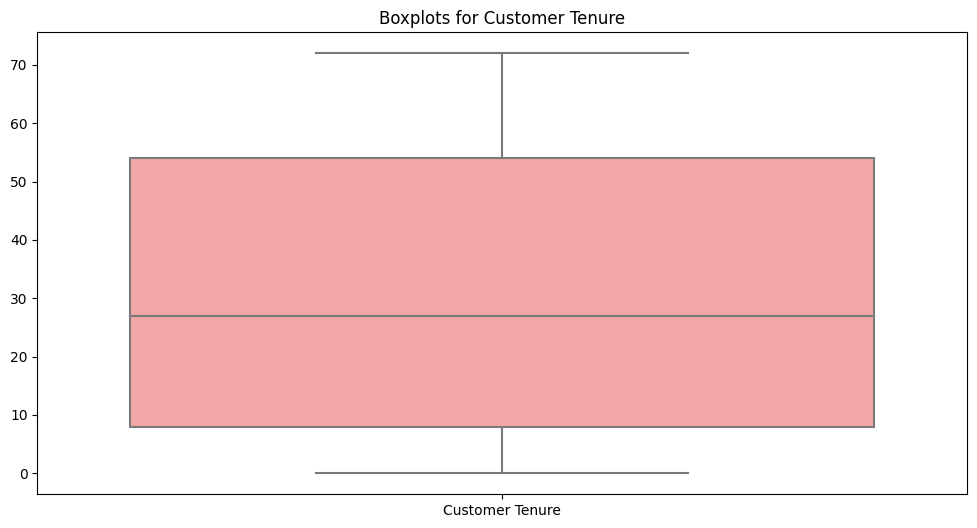

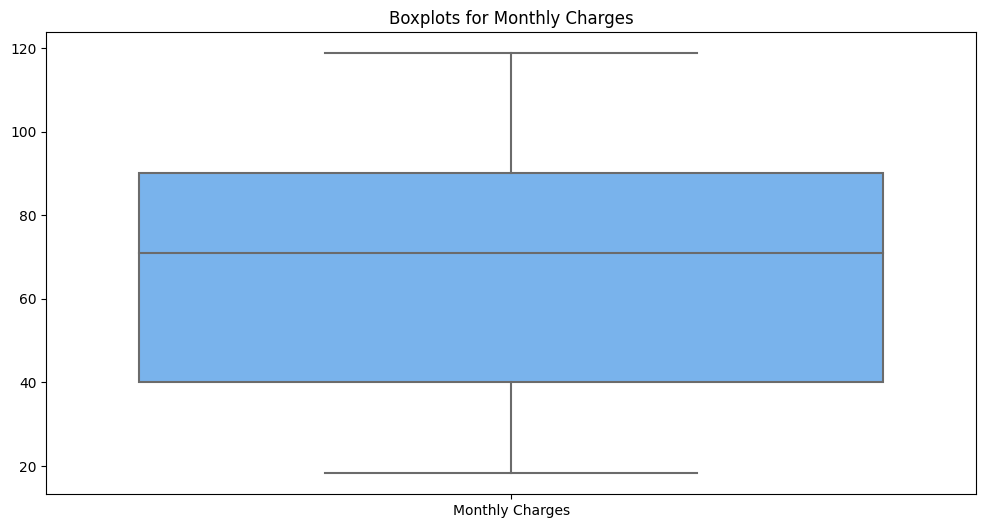

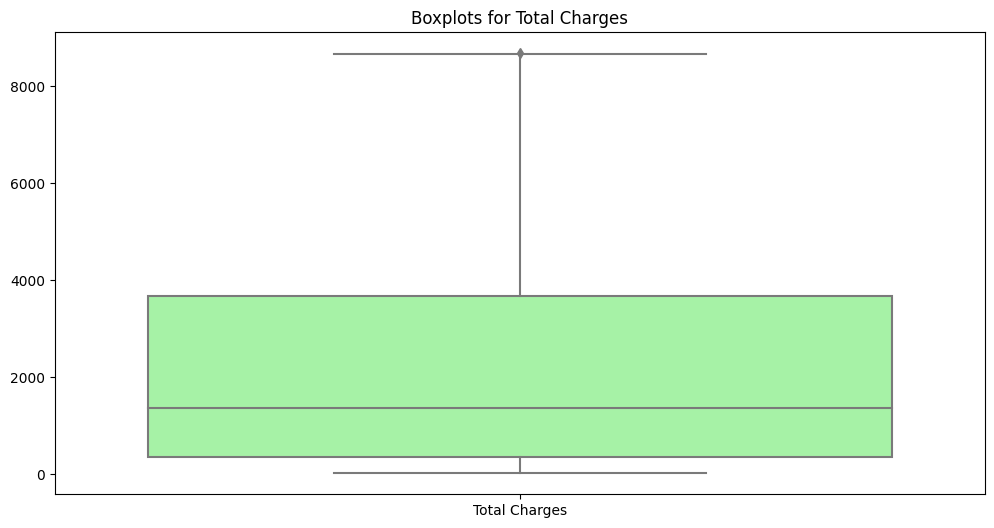

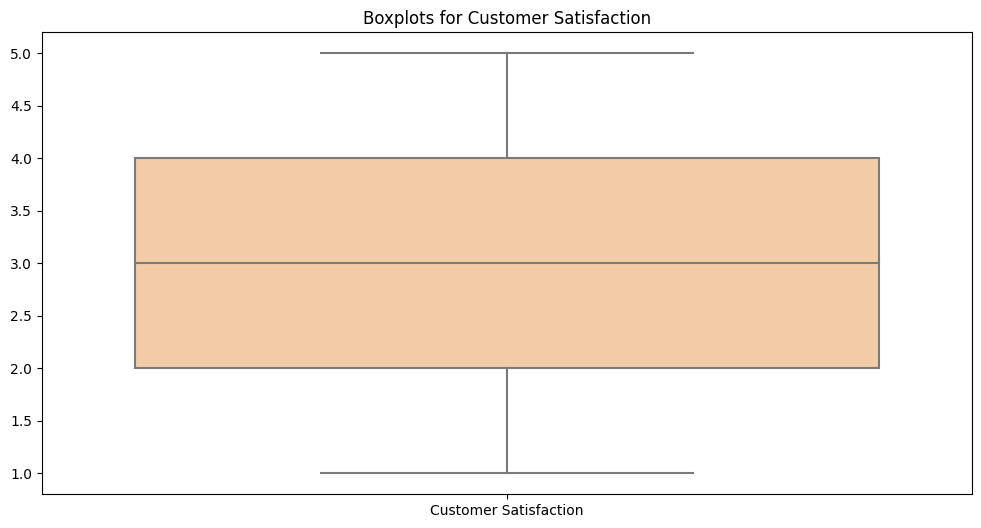

In [10]:
# Plotting box plots for numerical features

colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99']

plt.figure(figsize=(12, 6))
sns.boxplot(data=data_encoded[['Customer Tenure']], palette=[colors[0]])
plt.title('Boxplots for Customer Tenure')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=data_encoded[['Monthly Charges']], palette=[colors[1]])
plt.title('Boxplots for Monthly Charges')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=data_encoded[['Total Charges']], palette=[colors[2]])
plt.title('Boxplots for Total Charges')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=data_encoded[['Customer Satisfaction']], palette=[colors[3]])
plt.title('Boxplots for Customer Satisfaction')
plt.show()

In [11]:
# Checking numnerical features for outliers

numerical_columns = ['Customer Tenure', 'Monthly Charges', 'Total Charges', 'Customer Satisfaction']

def print_outliers(data, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Defining boundaries for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

    # Printing outlier rows
    print(f"Rows with Outliers in '{column}':")
    print(outliers)
    print("\n") 

for col in numerical_columns:
    print_outliers(data_encoded, col)

Rows with Outliers in 'Customer Tenure':
Empty DataFrame
Columns: [Customer Tenure, Monthly Charges, Total Charges, Customer Satisfaction, Customer Gender_Male, Is Senior_Y, Partner_Y, Dependents_Y, Has Phone Service_Y, Multiple Lines_No phone service, Multiple Lines_Y, Internet Plan_Fiber optic, Internet Plan_No, Online Security_No internet service, Online Security_Y, Device Protection_No internet service, Device Protection_Y, Tech Support_No internet service, Tech Support_Y, Streaming TV_No internet service, Streaming TV_Y, Streaming Movies_No internet service, Streaming Movies_Y, Contract_One year, Contract_Two year, Paperless Billing_Y, Payment Method_Credit card (automatic), Payment Method_Electronic check, Payment Method_Mailed check, Churn Label_Y]
Index: []

[0 rows x 30 columns]


Rows with Outliers in 'Monthly Charges':
Empty DataFrame
Columns: [Customer Tenure, Monthly Charges, Total Charges, Customer Satisfaction, Customer Gender_Male, Is Senior_Y, Partner_Y, Dependents_Y, 

In [12]:
# Only one outlier row found which will be kept in the data
# Calculating statistics for features
statistics = data_encoded.describe()
print(statistics)

       Customer Tenure  Monthly Charges  Total Charges  Customer Satisfaction  \
count      6000.000000      6000.000000    6000.000000            6000.000000   
mean         31.437167        65.516742    2236.679158               3.012500   
std          24.578705        29.887714    2259.172614               1.420451   
min           0.000000        18.250000      18.800000               1.000000   
25%           8.000000        39.975000     360.287500               2.000000   
50%          27.000000        70.900000    1356.900000               3.000000   
75%          54.000000        90.150000    3685.225000               4.000000   
max          72.000000       118.750000    8684.800000               5.000000   

       Customer Gender_Male  Is Senior_Y    Partner_Y  Dependents_Y  \
count           6000.000000  6000.000000  6000.000000   6000.000000   
mean               0.504667     0.167167     0.475000      0.209500   
std                0.500020     0.373156     0.499416    

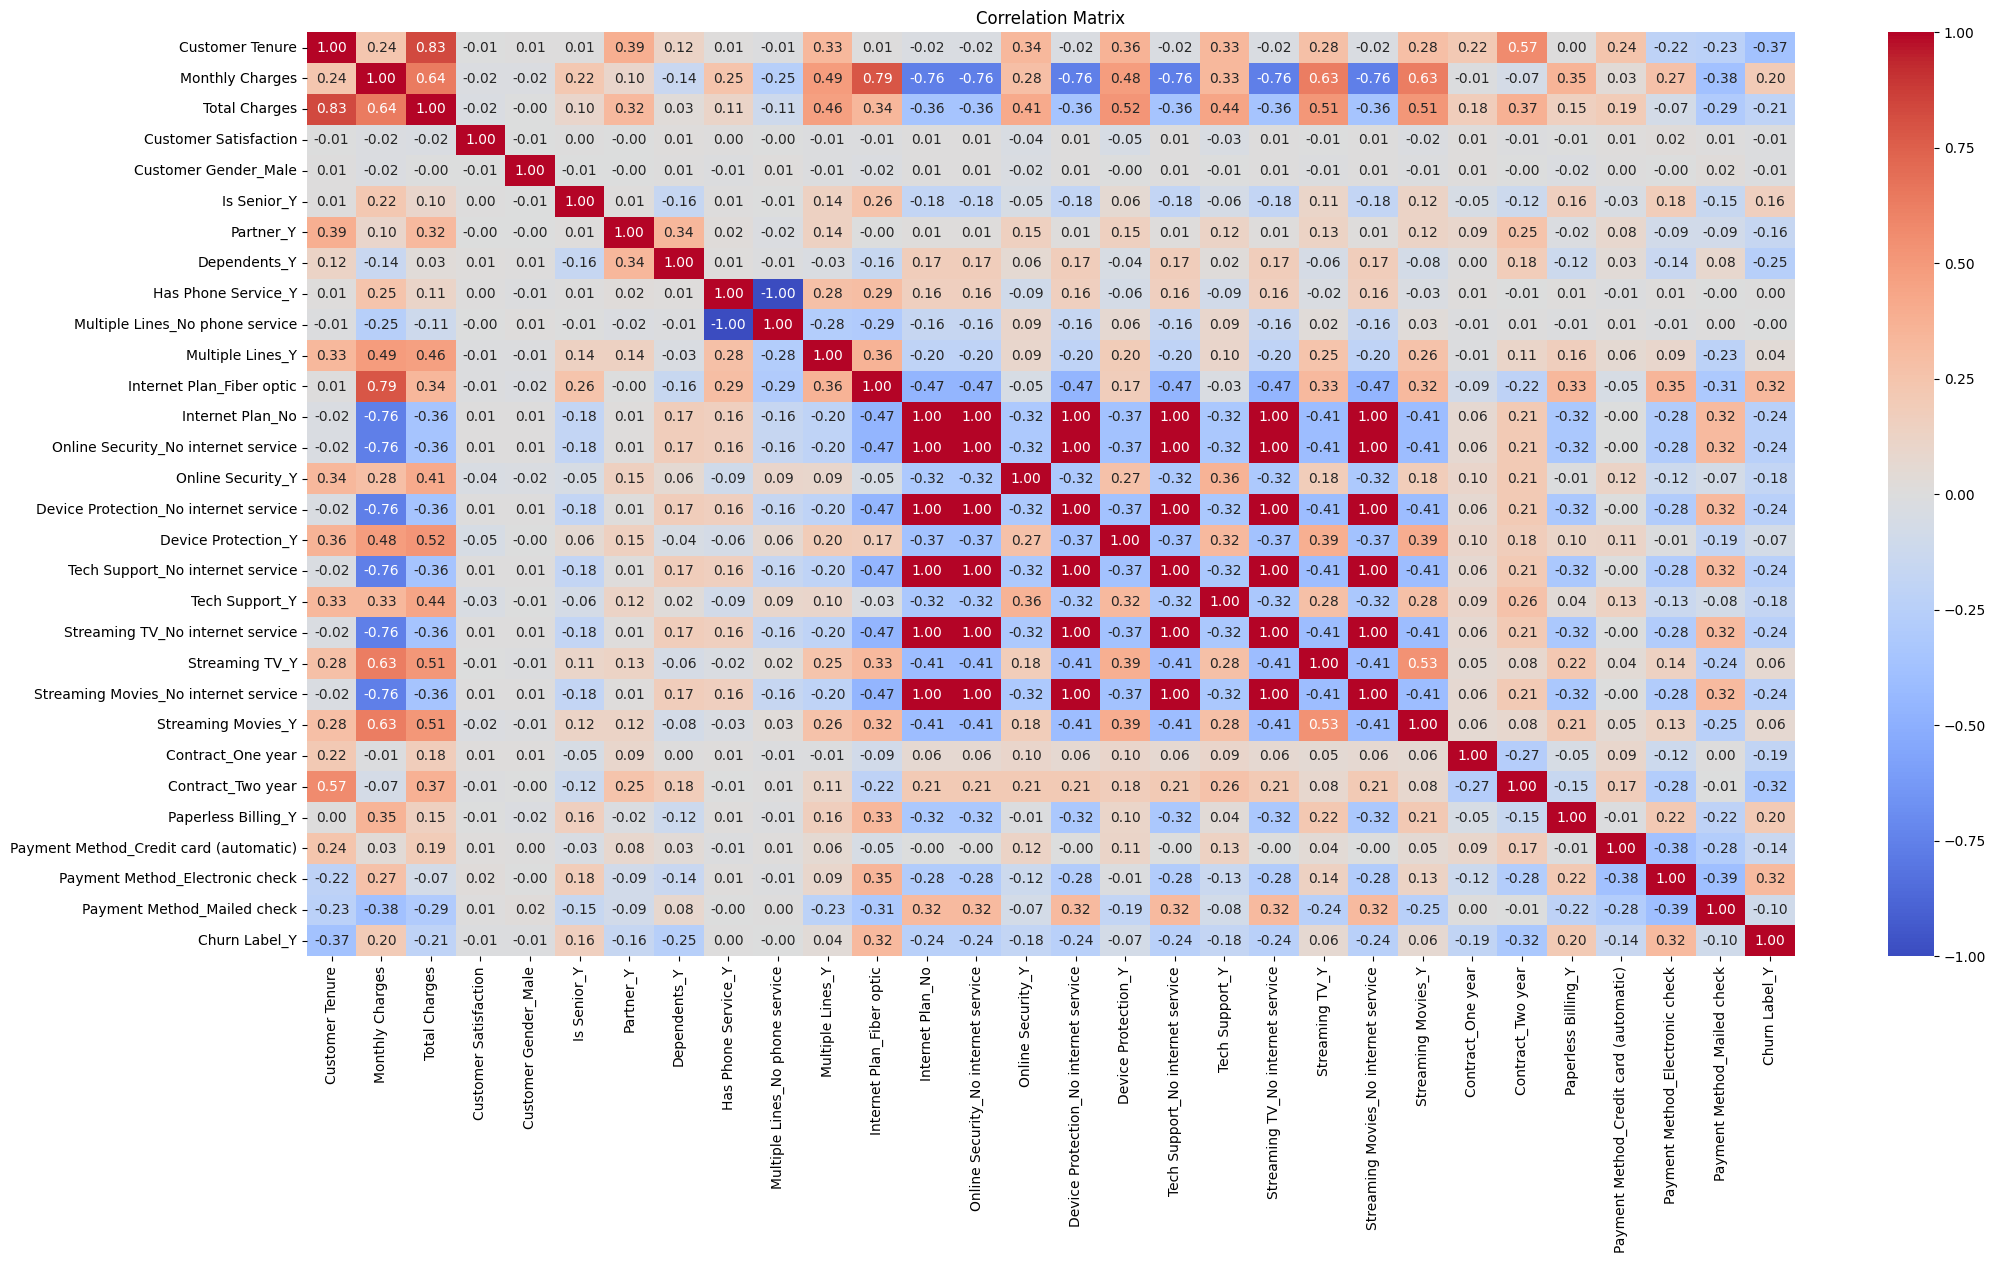

In [13]:
# Calculating correaltion matrix for features
correlation_matrix = data_encoded.corr()
plt.figure(figsize=(24, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [14]:
# Calculating top positive and negative correaltions for features with Churn
churn_correlations = correlation_matrix['Churn Label_Y']

sorted_correlations = churn_correlations.sort_values(ascending=False)

top_positive = sorted_correlations[sorted_correlations > 0].head(20)

top_negative = sorted_correlations[sorted_correlations < 0].sort_values(ascending=True).head(20)

print("Top Positive Correlations with Churn Label_Y:")
print(top_positive)

print("\nTop Negative Correlations with Churn Label_Y:")
print(top_negative)

Top Positive Correlations with Churn Label_Y:
Churn Label_Y                      1.000000
Internet Plan_Fiber optic          0.320888
Payment Method_Electronic check    0.317227
Paperless Billing_Y                0.203162
Monthly Charges                    0.200867
Is Senior_Y                        0.157763
Streaming TV_Y                     0.064898
Streaming Movies_Y                 0.063389
Multiple Lines_Y                   0.037559
Has Phone Service_Y                0.004730
Name: Churn Label_Y, dtype: float64

Top Negative Correlations with Churn Label_Y:
Customer Tenure                          -0.368329
Contract_Two year                        -0.321792
Dependents_Y                             -0.252531
Internet Plan_No                         -0.243487
Online Security_No internet service      -0.243487
Tech Support_No internet service         -0.243487
Streaming TV_No internet service         -0.243487
Streaming Movies_No internet service     -0.243487
Device Protection_No in

In [15]:
# Calculating feature pairs based on their correaltion between each other

correlation_pairs = correlation_matrix.unstack()

correlation_pairs = correlation_pairs[correlation_pairs < 1]

sorted_pairs = correlation_pairs.abs().sort_values(ascending=False)

unique_pairs = pd.DataFrame(sorted_pairs).reset_index()
unique_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

unique_pairs['Sorted Pair'] = unique_pairs.apply(lambda x: tuple(sorted([x['Feature 1'], x['Feature 2']])), axis=1)
unique_pairs = unique_pairs.drop_duplicates(subset='Sorted Pair').drop(columns='Sorted Pair')

top_correlated_pairs = unique_pairs.head(20)

print("Top Correlated Feature Pairs:")
print(top_correlated_pairs)

Top Correlated Feature Pairs:
                                Feature 1  \
0                     Has Phone Service_Y   
2                           Total Charges   
4                         Monthly Charges   
6   Device Protection_No internet service   
7                         Monthly Charges   
8                         Monthly Charges   
10                        Monthly Charges   
11                        Monthly Charges   
13                        Monthly Charges   
18                          Total Charges   
20                         Streaming TV_Y   
22                     Streaming Movies_Y   
24                        Customer Tenure   
26                     Streaming Movies_Y   
28                    Device Protection_Y   
30                     Streaming Movies_Y   
32                         Streaming TV_Y   
34                        Monthly Charges   
36                    Device Protection_Y   
38              Internet Plan_Fiber optic   

                        

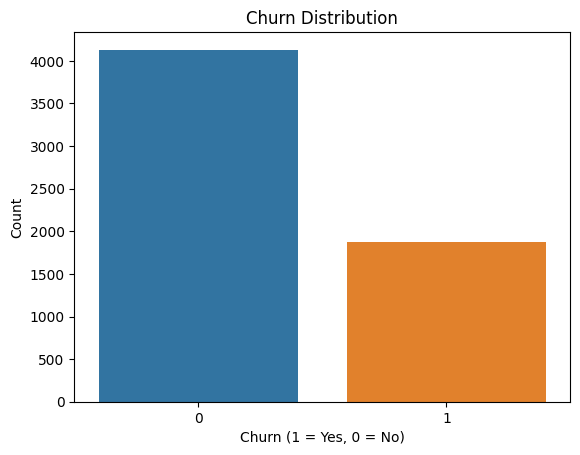

In [16]:
# Visualizing distribution of target variable
sns.countplot(x='Churn Label_Y', data=data_encoded)
plt.title('Churn Distribution')
plt.xlabel('Churn (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

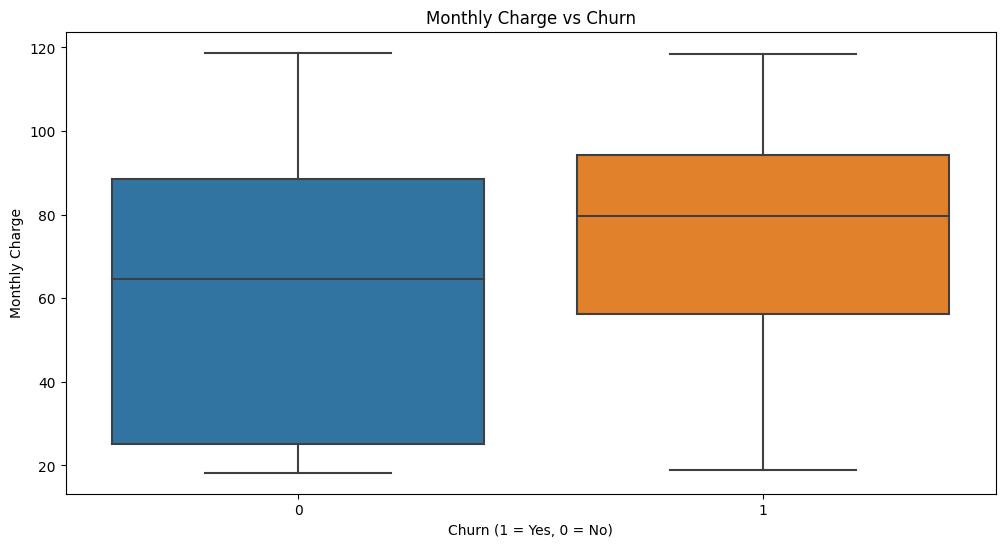

In [17]:
# Visualizing monthly charges vs churn
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn Label_Y', y='Monthly Charges', data=data_encoded)
plt.title('Monthly Charge vs Churn')
plt.xlabel('Churn (1 = Yes, 0 = No)')
plt.ylabel('Monthly Charge')
plt.show()

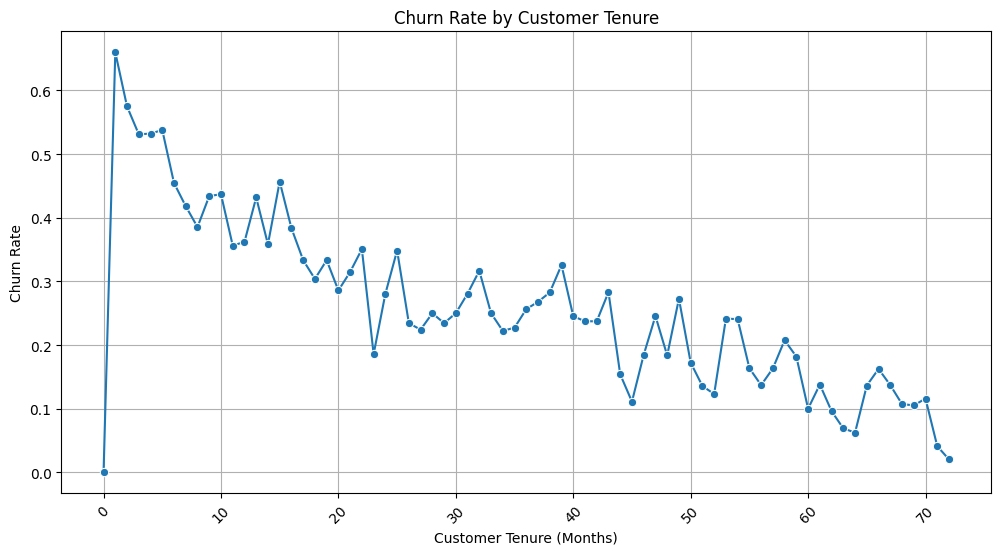

In [18]:
# Visualizing churn rate by customer tenure

churn_by_tenure = data_encoded.groupby('Customer Tenure')['Churn Label_Y'].mean().reset_index()

churn_by_tenure.columns = ['Customer Tenure', 'Churn Rate']

plt.figure(figsize=(12, 6))
sns.lineplot(data=churn_by_tenure, x='Customer Tenure', y='Churn Rate', marker='o')
plt.title('Churn Rate by Customer Tenure')
plt.xlabel('Customer Tenure (Months)')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.grid()
plt.show()

                                   Feature  Average Churn Rate
0                          Customer Tenure            0.258674
1                          Monthly Charges            0.313323
2                            Total Charges            0.298316
3                    Customer Satisfaction            0.311523
4                     Customer Gender_Male            0.311541
5                              Is Senior_Y            0.376672
6                                Partner_Y            0.307845
7                             Dependents_Y            0.228017
8                      Has Phone Service_Y            0.308430
9          Multiple Lines_No phone service            0.308430
10                        Multiple Lines_Y            0.314061
11               Internet Plan_Fiber optic            0.324528
12                        Internet Plan_No            0.230025
13     Online Security_No internet service            0.230025
14                       Online Security_Y            0

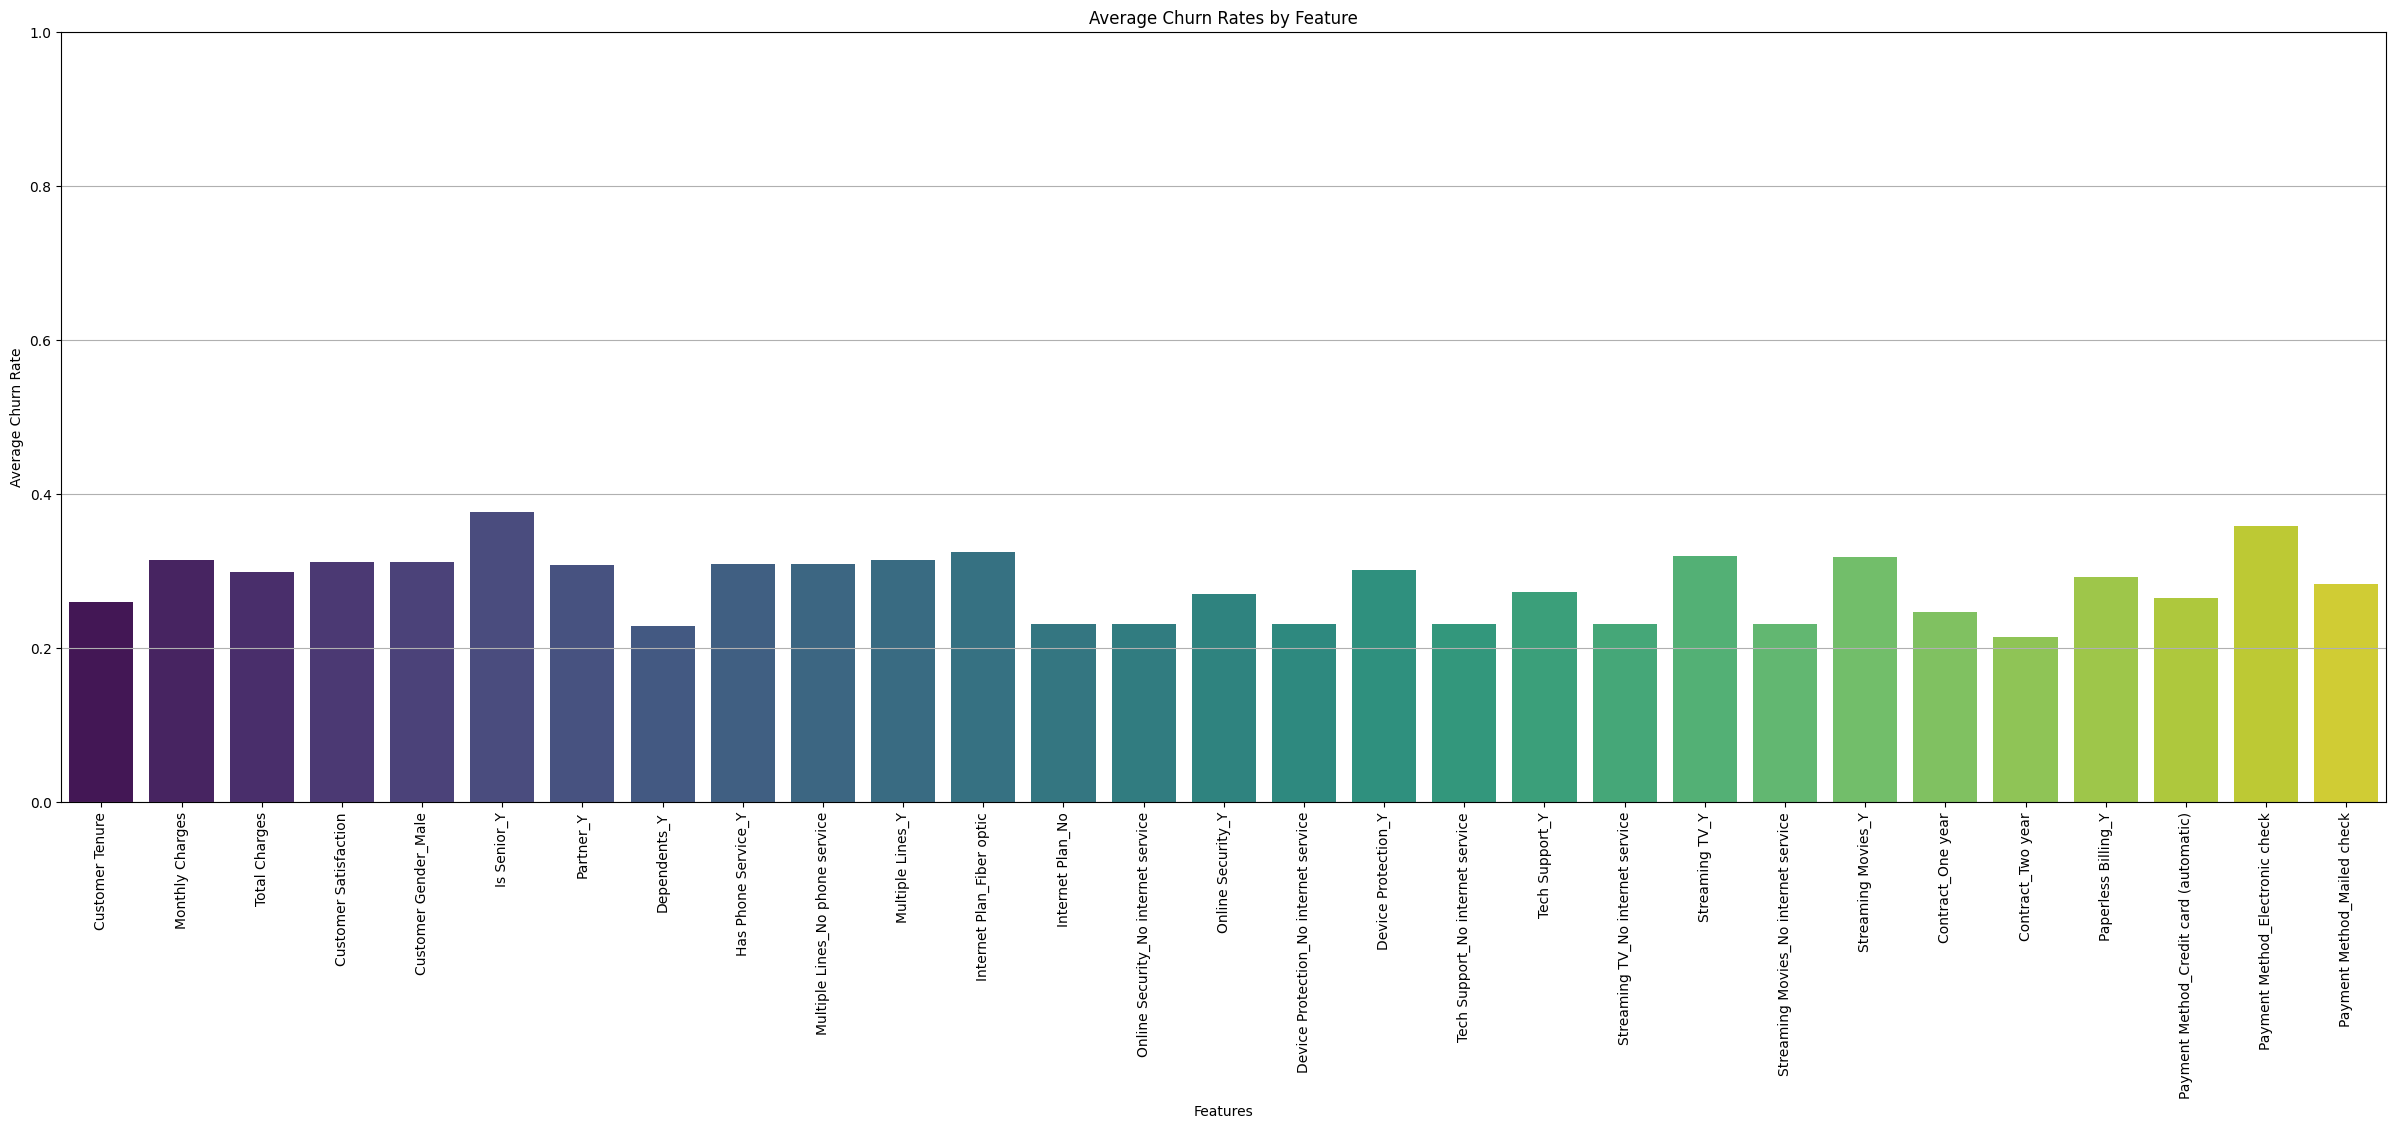

In [19]:
# Visualizing avergae churn rates for features

features = data_encoded.columns.drop('Churn Label_Y')

average_churn_rates = {}

for feature in features:
    if feature in data_encoded.columns:
        average_churn_rate = data_encoded.groupby(feature)['Churn Label_Y'].mean()
        average_churn_rates[feature] = average_churn_rate.mean()  
    else:
        print(f"Feature '{feature}' not found in DataFrame.")

average_churn_df = pd.DataFrame(list(average_churn_rates.items()), columns=['Feature', 'Average Churn Rate'])

print(average_churn_df)

if average_churn_df.empty:
    print("The average churn DataFrame is empty. Please check the calculations.")
else:
    plt.figure(figsize=(30, 10))
    sns.barplot(data=average_churn_df, x='Feature', y='Average Churn Rate', palette='viridis')
    plt.title('Average Churn Rates by Feature')
    plt.xlabel('Features')
    plt.ylabel('Average Churn Rate')
    plt.xticks(rotation=90)
    plt.ylim(0, 1) 
    plt.grid(axis='y')
    plt.show()

   Gender  Average Churn Rate
0  Female            0.315949
1    Male            0.307133


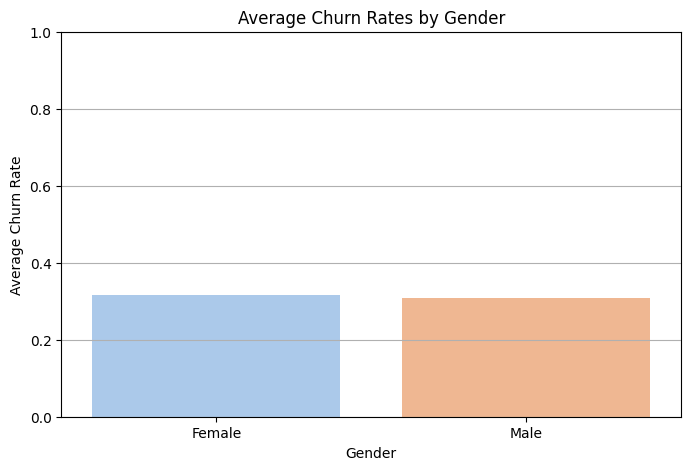

In [20]:
# Visualizing churn rates by gender

data['Churn Label'] = data['Churn Label'].map({'N': 0, 'Y': 1})

data['Customer Gender'] = data['Customer Gender'].fillna('Unknown')

average_churn_by_gender = data.groupby('Customer Gender')['Churn Label'].mean().reset_index()

average_churn_by_gender.columns = ['Gender', 'Average Churn Rate']

print(average_churn_by_gender)

plt.figure(figsize=(8, 5))
sns.barplot(data=average_churn_by_gender, x='Gender', y='Average Churn Rate', palette='pastel')
plt.title('Average Churn Rates by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Churn Rate')
plt.ylim(0, 1)  
plt.grid(axis='y')
plt.show()

                 Retained  Churned
Customer Gender                   
Female               2033      939
Male                 2098      930


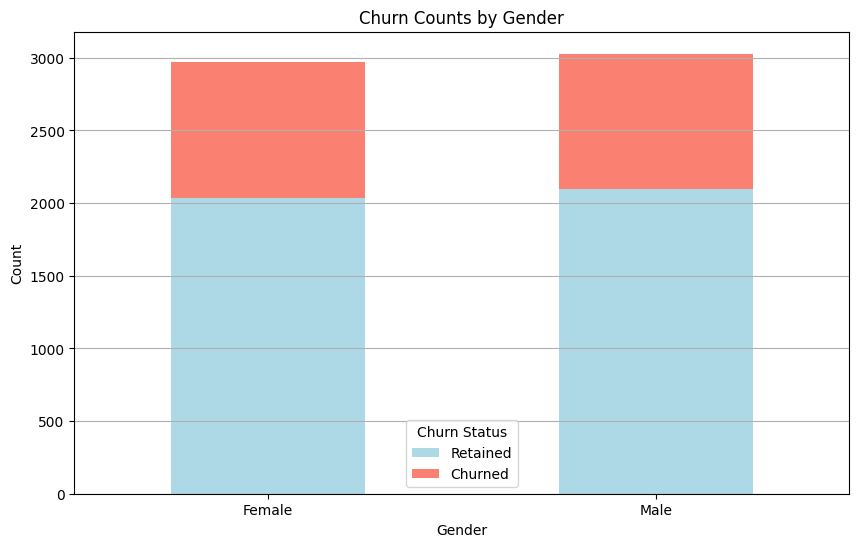

In [21]:
# Visualizing churn counts by gender

churn_counts = data.groupby(['Customer Gender', 'Churn Label']).size().unstack(fill_value=0)

churn_counts.columns = ['Retained', 'Churned']

print(churn_counts)

churn_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'salmon'])
plt.title('Churn Counts by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Churn Status', labels=['Retained', 'Churned'])
plt.grid(axis='y')
plt.show()

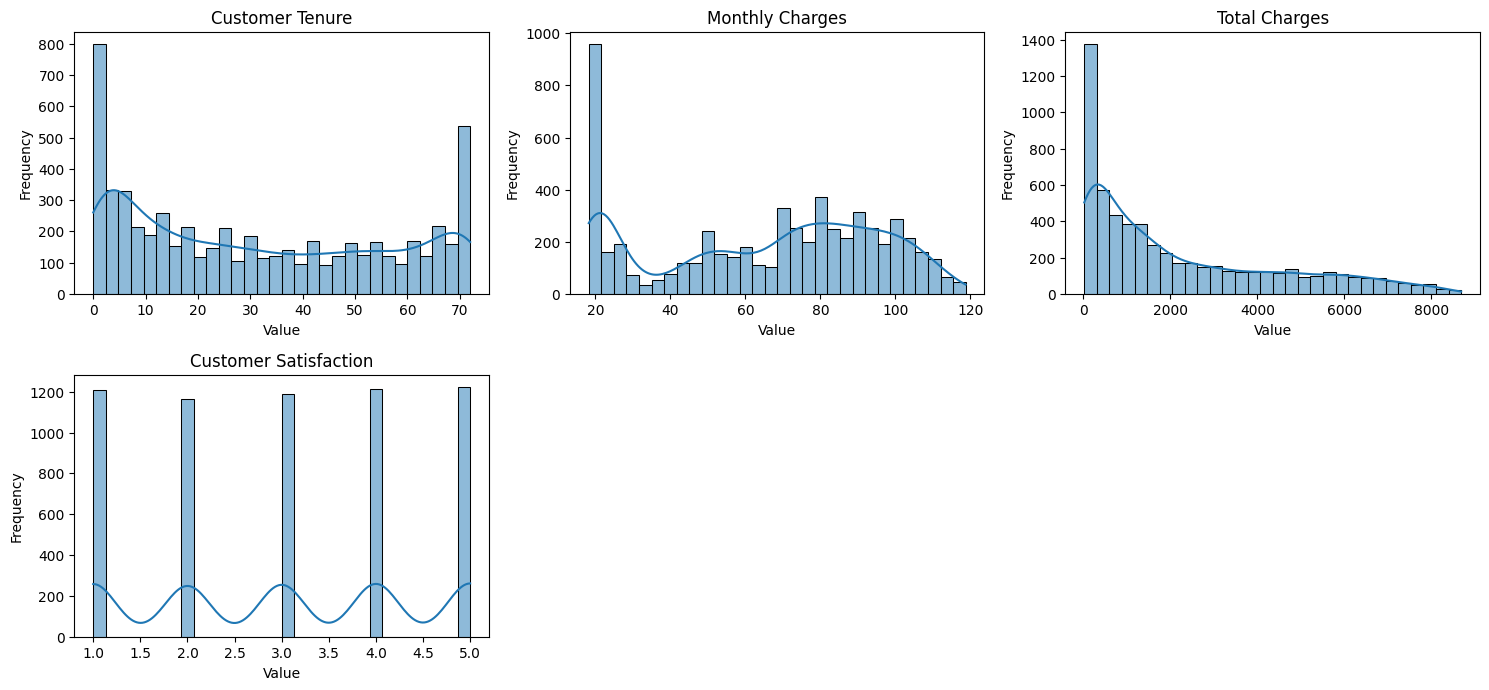

In [22]:
# Visualizing distribution of numerical features

numerical_features = data_encoded.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)  
    sns.histplot(data_encoded[feature], bins=30, kde=True)
    plt.title(feature)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [23]:
# Features do not follow gaussian distribution so standardization of features is unsuitable. Since no careful analysis of outliers was performed features will aslo not be normalized.

# Filtering features based on correlation tresholds

correlation_with_target = correlation_matrix['Churn Label_Y']

filtered_features = correlation_with_target[(correlation_with_target > 0.1) | (correlation_with_target < -0.1)]

filtered_features = filtered_features.drop('Churn Label_Y')

filtered_feature_list = filtered_features.index.tolist()

# Display the filtered feature list
print("Filtered Features with Correlation > 0.1 or < -0.1 with Churn Label_Y:")
print(filtered_feature_list)

Filtered Features with Correlation > 0.1 or < -0.1 with Churn Label_Y:
['Customer Tenure', 'Monthly Charges', 'Total Charges', 'Is Senior_Y', 'Partner_Y', 'Dependents_Y', 'Internet Plan_Fiber optic', 'Internet Plan_No', 'Online Security_No internet service', 'Online Security_Y', 'Device Protection_No internet service', 'Tech Support_No internet service', 'Tech Support_Y', 'Streaming TV_No internet service', 'Streaming Movies_No internet service', 'Contract_One year', 'Contract_Two year', 'Paperless Billing_Y', 'Payment Method_Credit card (automatic)', 'Payment Method_Electronic check']


# Model building

In [24]:
# Initializing variables

X = data_encoded[filtered_feature_list]  # Features
y = data_encoded['Churn Label_Y']  # Target variable

# Splitting dataset into train and test set with 20/80 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

## Baseline logistic regression model

Logistic Regression Model:
Confusion Matrix:
[[709  97]
 [152 242]]


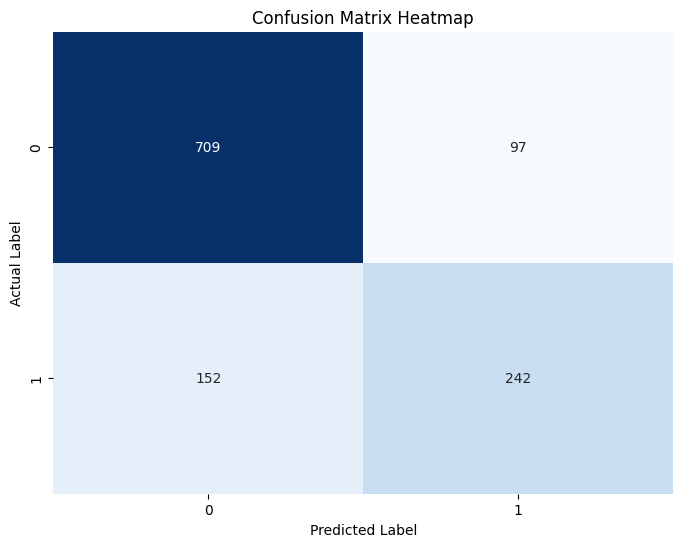

Logistic Regression Model:
Accuracy: 0.7925
ROC AUC Score: 0.8582443224043027
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       806
           1       0.71      0.61      0.66       394

    accuracy                           0.79      1200
   macro avg       0.77      0.75      0.76      1200
weighted avg       0.79      0.79      0.79      1200



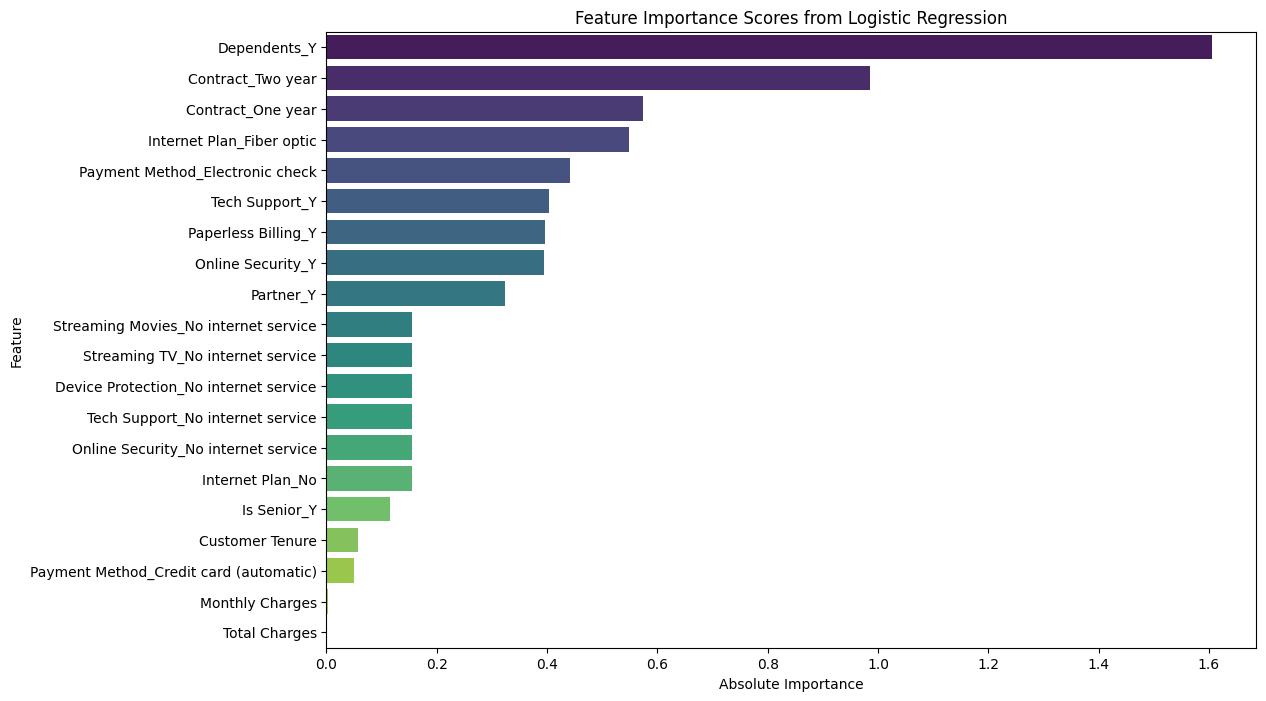

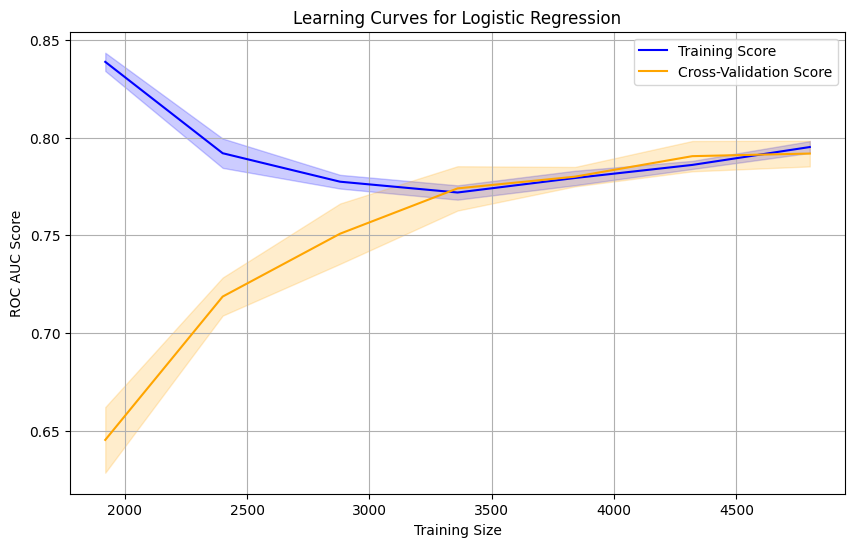

In [25]:
logistic_model = LogisticRegression(max_iter=10000)
logistic_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_logistic)
class_report = classification_report(y_test, y_pred_logistic)

accuracy = accuracy_score(y_test, y_pred_logistic)
roc_auc = roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])

print("Logistic Regression Model:")
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("Logistic Regression Model:")
print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)

print("Classification Report:")
print(class_report)

# Feature importance scores
importance_scores = logistic_model.fit(X, y).coef_[0]

features = [col for col in X.columns]

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance_scores
})

importance_df['Absolute Importance'] = importance_df['Importance'].abs()
importance_df = importance_df.sort_values(by='Absolute Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Absolute Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance Scores from Logistic Regression')
plt.xlabel('Absolute Importance')
plt.ylabel('Feature')
plt.show()

# Learning Curves
train_sizes, train_scores, test_scores = learning_curve(logistic_model, X, y, 
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', color='orange')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, color='orange', alpha=0.2)

plt.title('Learning Curves for Logistic Regression')
plt.xlabel('Training Size')
plt.ylabel('ROC AUC Score')
plt.legend(loc='best')
plt.grid()
plt.show()

## Decison Tree Model

In [26]:
decision_tree = DecisionTreeClassifier(random_state=100)
decision_tree.fit(X_train, y_train)

y_pred_tree = decision_tree.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_tree)
class_report = classification_report(y_test, y_pred_tree)

accuracy = accuracy_score(y_test, y_pred_tree)
roc_auc = roc_auc_score(y_test, decision_tree.predict_proba(X_test)[:, 1])

print("Decision Tree model:")
print("ROC AUC Score:", roc_auc)

print("Classification Report:")
print(class_report)

Decision Tree model:
ROC AUC Score: 0.6710348150294114
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       806
           1       0.57      0.54      0.55       394

    accuracy                           0.71      1200
   macro avg       0.67      0.67      0.67      1200
weighted avg       0.71      0.71      0.71      1200



## Bagging with decision trees

In [27]:
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=1000, random_state=100)
bagging_model.fit(X_train, y_train)

y_pred_bagging = bagging_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_bagging)
class_report = classification_report(y_test, y_pred_bagging)

accuracy = accuracy_score(y_test, y_pred_bagging)
roc_auc = roc_auc_score(y_test, bagging_model.predict_proba(X_test)[:, 1])

print("Bagging Model:")
print("ROC AUC Score:", roc_auc)

print("Classification Report:")
print(class_report)

Bagging Model:
ROC AUC Score: 0.8352127445176405
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       806
           1       0.68      0.57      0.62       394

    accuracy                           0.77      1200
   macro avg       0.74      0.72      0.73      1200
weighted avg       0.76      0.77      0.76      1200



## Random Forest Classifier

In [28]:
random_forest_model = RandomForestClassifier(random_state=100)
random_forest_model.fit(X_train, y_train)

y_pred_rf = random_forest_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf)

accuracy = accuracy_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, random_forest_model.predict_proba(X_test)[:, 1])

print("Random Forest model:")
print("ROC AUC Score:", roc_auc)

print("Classification Report:")
print(class_report)

Random Forest model:
ROC AUC Score: 0.8407958710685091
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       806
           1       0.69      0.56      0.62       394

    accuracy                           0.77      1200
   macro avg       0.75      0.72      0.73      1200
weighted avg       0.77      0.77      0.77      1200



## Parameter Optimization with Grid Search

Optimized Random Forest Model Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 100, 'verbose': 0, 'warm_start': False}


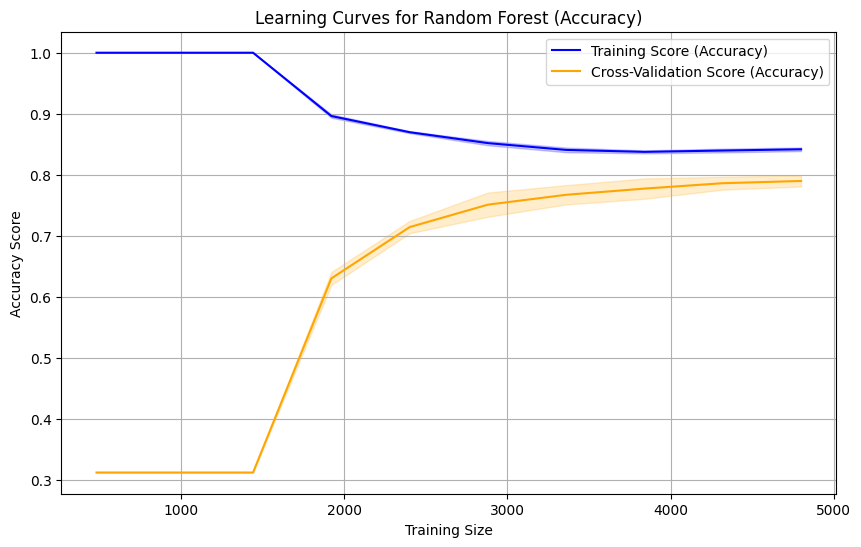

Optimized Random Forest Model:
ROC AUC Score: 0.8642997946870551
Confusion Matrix:
[[712  94]
 [155 239]]


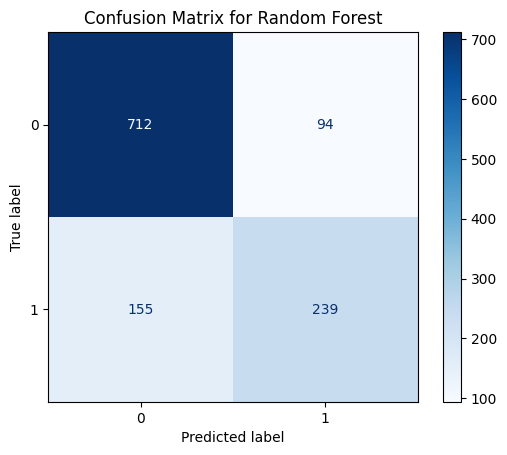

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       806
           1       0.72      0.61      0.66       394

    accuracy                           0.79      1200
   macro avg       0.77      0.74      0.75      1200
weighted avg       0.79      0.79      0.79      1200



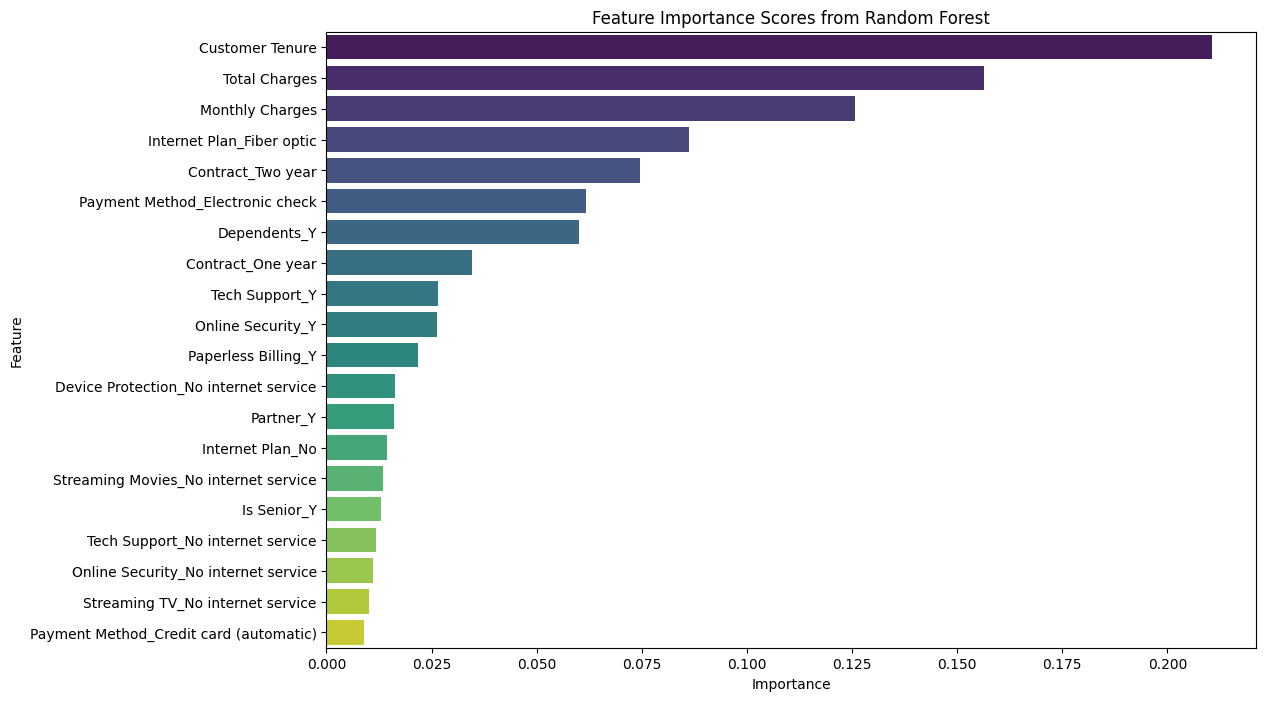

In [31]:
# Distribution of yes and no for churn very uneven so ROC AUC will be used as defining metric instead of accuracy

# Decision Tree
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=100), dt_param_grid, cv=5, scoring='roc_auc')
dt_grid_search.fit(X_train, y_train)
best_dt_model = dt_grid_search.best_estimator_
roc_auc_dt = roc_auc_score(y_test, best_dt_model.predict_proba(X_test)[:, 1])

# Bagging Classifier
bagging_param_grid = {
    'n_estimators': [10, 50, 100],
    'base_estimator__max_depth': [None, 10, 20],
    'base_estimator__min_samples_split': [2, 5],
}

bagging_grid_search = GridSearchCV(BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=100), 
                                    bagging_param_grid, cv=5, scoring='roc_auc')
bagging_grid_search.fit(X_train, y_train)
best_bagging_model = bagging_grid_search.best_estimator_
roc_auc_bagging = roc_auc_score(y_test, best_bagging_model.predict_proba(X_test)[:, 1])

# Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=100), rf_param_grid, cv=5, scoring='roc_auc')
rf_grid_search.fit(X_train, y_train)
best_rf_model = rf_grid_search.best_estimator_
roc_auc_rf = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])

# Best model based on ROC AUC score
best_model, best_roc_auc = None, 0
if roc_auc_dt >= roc_auc_bagging and roc_auc_dt >= roc_auc_rf:
    best_model = best_dt_model
    best_roc_auc = roc_auc_dt
    model_name = "Decision Tree"
elif roc_auc_bagging >= roc_auc_dt and roc_auc_bagging >= roc_auc_rf:
    best_model = best_bagging_model
    best_roc_auc = roc_auc_bagging
    model_name = "Bagging Classifier"
else:
    best_model = best_rf_model
    best_roc_auc = roc_auc_rf
    model_name = "Random Forest"

print(f"Optimized {model_name} Model Parameters:")
print(best_model.get_params())

# Learning curve for the best model using accuracy
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, 
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score (Accuracy)', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score (Accuracy)', color='orange')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, color='orange', alpha=0.2)
plt.title(f'Learning Curves for {model_name} (Accuracy)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# Evaluating best model
y_pred_best = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_best)
class_report = classification_report(y_test, y_pred_best)

print(f"Optimized {model_name} Model:")
print("ROC AUC Score:", best_roc_auc)
print("Confusion Matrix:")
print(conf_matrix)

ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

print("Classification Report:")
print(class_report)

# feature importance of best model
if hasattr(best_model, 'feature_importances_'):
    importance_scores = best_model.feature_importances_
    features = [col for col in X.columns]

    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importance_scores
    })

    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(f'Feature Importance Scores from {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()